In [36]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
raw_data = yf.download("BTC-USD", start="2000-01-01")
raw_data.shape

[*********************100%***********************]  1 of 1 completed


(3151, 6)

<Axes: xlabel='Date'>

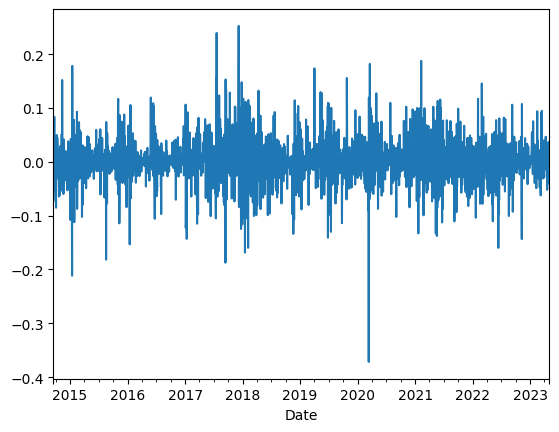

In [47]:
raw_data["pct_change"].plot()

In [3]:
raw_data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

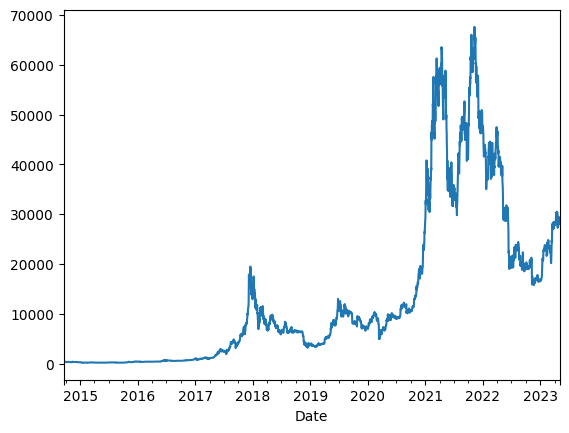

In [4]:
raw_data["Adj Close"].plot()

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(raw_data["Adj Close"].values.reshape(-1, 1))

In [6]:
def split_features(df, window_size):
    x, y = [], []

    for i in range(len(df) - window_size):
        row = [[a] for a in df[i : i + window_size]]
        x.append(row)
        label = df[i + window_size]
        y.append(label)

    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2])

    y = np.array(y)

    return x, y


In [7]:
x, y = split_features(scaled_data, 50)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=42, shuffle=False
)


In [9]:
def model_builder(hp):
    model = Sequential()

    model.add(
        LSTM(
            units=hp.Int("input_LSTM", min_value=12, max_value=96, step=12),
            input_shape=(x_train.shape[1], x_train.shape[2]),
            activation=hp.Choice("input_act", ["relu", "tanh", "sigmoid"]),
            return_sequences=True,
        ),
    )
    model.add(Dropout(0.2))

    model.add(
        Bidirectional(
            LSTM(
                units=hp.Int("layer_1", min_value=12, max_value=96, step=12),
                activation=hp.Choice("act_1", ["relu", "tanh", "sigmoid"]),
                return_sequences=True,
            )
        )
    )
    model.add(Dropout(0.2))

    model.add(
        Bidirectional(
            LSTM(
                x_train.shape[1],
                return_sequences=False,
                activation=hp.Choice("act_2", ["relu", "tanh", "sigmoid"]),
            )
        )
    )

    model.add(Dense(1))
    model.add(Activation("linear"))

    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
    )

    return model

In [10]:
hp_tuner = kt.RandomSearch(
    model_builder,
    objective="val_loss",
    max_trials=10,
    directory="logs - randomSearch",
    project_name="rs_v1.0.1-BTC-USD",
)


In [11]:
earlyStop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [12]:
hp_tuner.search(
    x_train, y_train, epochs=10, validation_split=0.2, callbacks=[earlyStop]
)


Trial 10 Complete [00h 01m 00s]
val_loss: 0.005366003606468439

Best val_loss So Far: 0.003062122268602252
Total elapsed time: 00h 15m 04s
INFO:tensorflow:Oracle triggered exit


In [13]:
hpModel = hp_tuner.get_best_models()[0]

In [14]:
history = hpModel.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    shuffle=False,
    callbacks=earlyStop,
)


Epoch 1/10
70/70 [==============================] - 18s 143ms/step - loss: 3.0787e-04 - val_loss: 0.0274
Epoch 2/10
70/70 [==============================] - 8s 120ms/step - loss: 0.0031 - val_loss: 0.0684
Epoch 3/10
70/70 [==============================] - 8s 115ms/step - loss: 0.0038 - val_loss: 0.0193
Epoch 4/10
70/70 [==============================] - 8s 113ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 5/10
70/70 [==============================] - 8s 110ms/step - loss: 8.2736e-04 - val_loss: 0.0896
Epoch 6/10
70/70 [==============================] - 8s 109ms/step - loss: 8.2760e-04 - val_loss: 0.0165


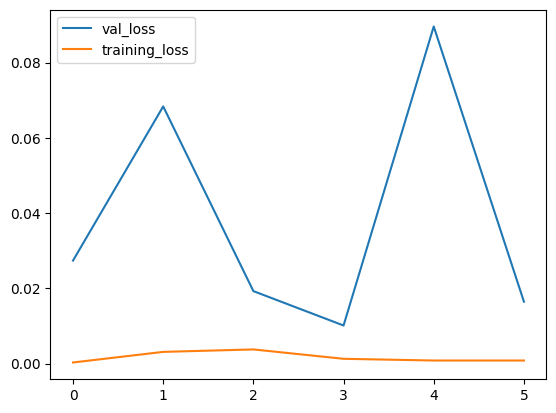

In [15]:
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["loss"], label="training_loss")
plt.legend()

10/10 [==============================] - 2s 26ms/step


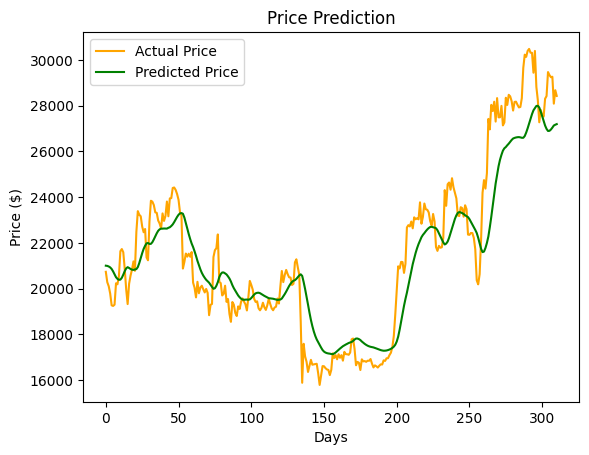

In [16]:
y_pred = hpModel.predict(x_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.plot(y_test_orig, label="Actual Price", color="orange")
plt.plot(y_pred_orig, label="Predicted Price", color="green")

plt.title("Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend(loc="best")


In [28]:
results_df = pd.DataFrame(data=[y_test_orig.flatten(), y_pred_orig.flatten()], index=["y_true", "y_pred"]).T
results_df

,y_true,y_pred
0,20735.478516,21003.042969
1,20280.634766,20993.826172
2,20104.023438,20968.005859
3,19784.726562,20927.996094
4,19269.367188,20859.535156
...,...,...
306,29248.488281,26959.500000
307,29268.806641,27042.121094
308,28091.568359,27135.275391
309,28680.537109,27169.107422


In [39]:
print(mean_absolute_error(results_df["y_true"], results_df["y_pred"])) 
print(mean_squared_error(results_df["y_true"], results_df["y_pred"]))

1137.304316971463
2178356.616124702
